In [216]:
import numpy as np
import pandas as pd

In [217]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [218]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

In [219]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\heart_disease_uci.csv'
df = pd.read_csv(PATH)

In [220]:
df.drop(['id'], axis=1, inplace=True)

In [221]:
y = df['num'].apply(lambda x: x > 0)
X = df.drop(['num'], axis=1)

In [222]:
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [223]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [224]:
cols = X.columns
for col in cols:
    if X[col].dtype == 'O':
        X[col] = X[col].astype("category")

In [225]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [226]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred))

[[ 84  34]
 [ 26 132]]
f1_score is  0.8148148148148148


In [227]:
df.isnull().sum()

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [228]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def split_binarize(X, y, threshold=10):
    X.index = [str(id) for id in list(X.index)]
    y_bin = y.apply(lambda x: True if (x=='1' or x==1) else False)
    X = X.select_dtypes(include=['category'])
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3)

    def to_string(x):
        if type(x) not in ['string', 'float', 'int']:
            return str(x)
        return x

    cols = X.columns
    onehotencoder = OneHotEncoder()
    X_train_bin = X_train.copy()
    X_test_bin = X_test.copy()

    for col in cols:
        if X_train[col].isnull().sum() > 0:
            X_train[col] = X_train[col].cat.add_categories(['Unknown'])
            X_test[col] = X_test[col].cat.add_categories(['Unknown'])
            X_train[col] = X_train[col].fillna("Unknown")
            X_test[col] = X_test[col].fillna("Unknown")

    for col in cols:
        if len(X_train[col].value_counts()) > 10:
            continue
        X_train[col] = X_train[col].apply(to_string)
        X_test[col] = X_test[col].apply(to_string)
        res = onehotencoder.fit_transform(X_train[[col]])
        X_train_bin[onehotencoder.categories_[0]] = res.toarray()
        res = onehotencoder.transform(X_test[[col]])
        X_test_bin[onehotencoder.categories_[0]] = res.toarray()

        X_train_bin.drop([col], axis=1, inplace=True)
        X_test_bin.drop([col], axis=1, inplace=True)


    cols = X_train_bin.columns
    for col in cols:
        X_train_bin[col] = X_train_bin[col].apply(lambda x : False if (x==0 or x == '0') else True)
        X_test_bin[col] = X_test_bin[col].apply(lambda x : False if (x==0 or x == '0') else True)

    return X_train_bin, X_test_bin, y_train, y_test


In [229]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = split_binarize(X, y)

In [230]:
K_train = FormalContext.from_pandas(X_train_bin)
K_train

FormalContext (644 objects, 21 attributes, 3851 connections)
   |Female|Male|Cleveland|Hungary|Switzerland|...|downsloping|flat|upsloping|fixed defect|reversable defect|
807|      |   X|         |       |           |...|           |    |         |            |                 |
222|     X|    |        X|       |           |...|           |    |        X|            |                 |
801|      |   X|         |       |           |...|          X|    |         |            |                 |
311|      |   X|         |      X|           |...|           |    |         |            |                 |
883|      |   X|         |       |           |...|           |    |         |            |                 |
211|      |   X|        X|       |           |...|           |   X|         |            |                X|
718|     X|    |         |       |          X|...|           |    |        X|            |                 |
376|     X|    |         |      X|           |...|           |    |

In [231]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')
len(L)

97

In [232]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train_bin, y_preds)

In [233]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:14])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects


True

In [234]:
L.measures['f1_score']

array([0.        , 0.11578947, 0.28699552, 0.50687623, 0.49708738,
       0.2840691 , 0.47723133, 0.52363636, 0.44927536, 0.28218695,
       0.3882149 , 0.35986159, 0.38687392, 0.33619211, 0.56905158,
       0.59800664, 0.65671642, 0.60096931, 0.44865719, 0.52283465,
       0.47887324, 0.60342146, 0.48062016, 0.38709677, 0.67278287,
       0.4109589 , 0.33738602, 0.37481259, 0.66268657, 0.52678571,
       0.40294118, 0.63688761, 0.51216023, 0.36571429, 0.64022663,
       0.50564972, 0.78028169, 0.54929577, 0.59103641, 0.48111888,
       0.59166667, 0.53846154, 0.58241758, 0.76268861, 0.53188602,
       0.45196211, 0.64420485, 0.50738255, 0.53351206, 0.43582888,
       0.63551402, 0.6045273 , 0.51724138, 0.44210526, 0.63350785,
       0.57915058, 0.52509653, 0.73307791, 0.80203046, 0.65239295,
       0.59473024, 0.65081352, 0.5917603 , 0.49815951, 0.69352869,
       0.68529769, 0.60436893, 0.60072376, 0.56694813, 0.71566265,
       0.62334537, 0.64981949, 0.58781362, 0.59690844, 0.69822

In [235]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train_bin)))

In [236]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [237]:
descr = {'Female', 'Male', 'Cleveland', 'flat'}

traced = cn.trace_description(descr, include_targets=False)

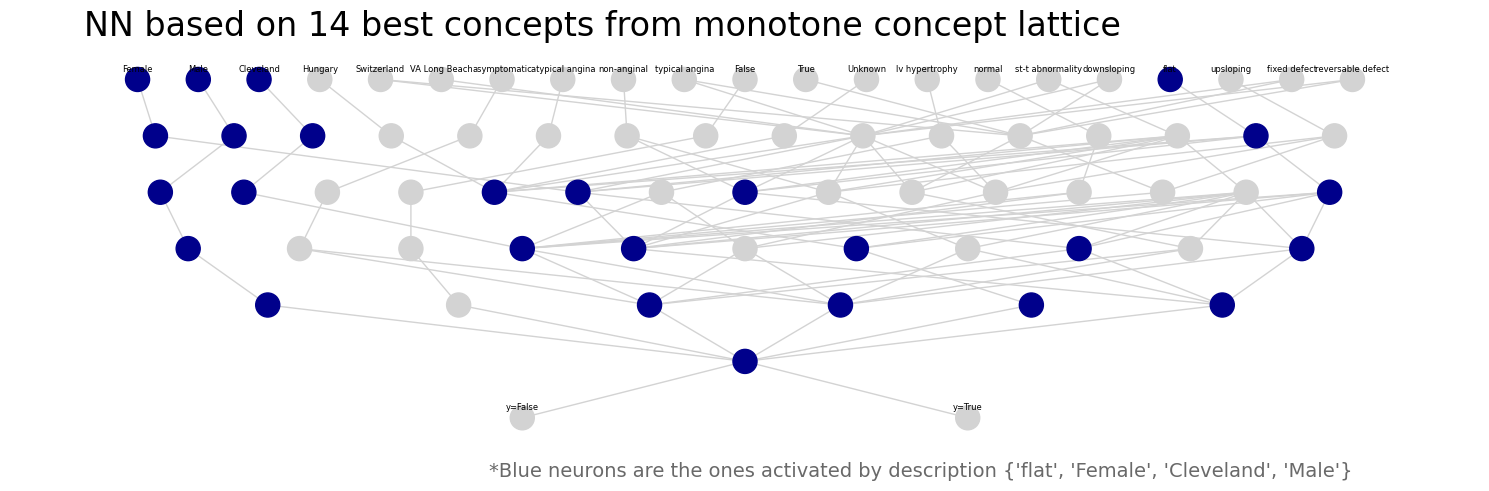

In [238]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 14 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [239]:
cn.fit(X_train_bin, y_train_bin)

In [240]:
print('Class prediction', cn.predict(X_test_bin).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test_bin).detach().numpy())
print('True class', y_test_bin.values)

Class prediction [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Class prediction with probabilities [[0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.40970445 0.5902955 ]
 [0.4097044

In [241]:
f1_score(cn.predict(X_test_bin).numpy(), y_test_bin)

0.7281105990783411

In [242]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train_bin, y_train_bin)

y_pred = xgb_model.predict(X_test_bin)

print(confusion_matrix(y_test_bin, y_pred))
print('f1_score is ', f1_score(y_test_bin, y_pred))

[[ 85  33]
 [ 22 136]]
f1_score is  0.8318042813455658


In [243]:
edge_weights = cn.edge_weights_from_network()

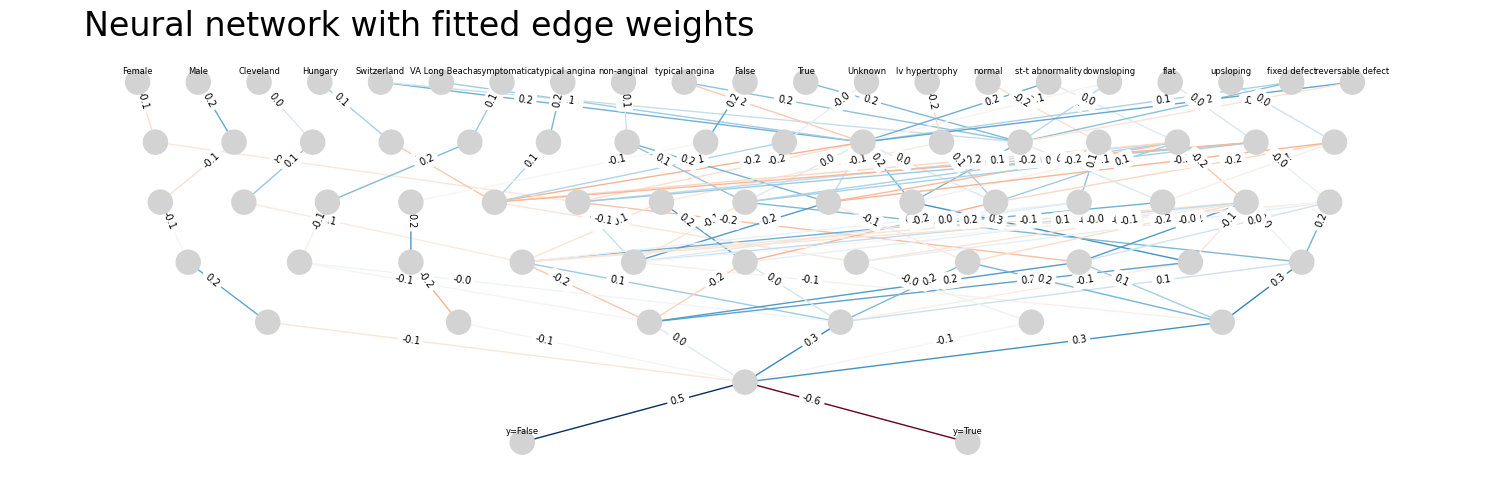

In [244]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

# 2. Wine quality

In [245]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\winequalityN.csv'
df = pd.read_csv(PATH)

In [246]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [247]:
X = df.drop(['quality'], axis=1)
y = df['quality']

In [328]:
def g(x):
    if 3<=x<=4:
        return 1
    if x==5:
        return 2
    if x ==6:
        return 3
    if x == 7:
        return 4
    if 8<=x<=9:
        return 5
    
y=y.apply(g)

In [329]:
#reduce the size of dataset
from sklearn.model_selection import train_test_split

X, X_tr, y, y_tr = train_test_split(X, y, test_size=11/13, stratify=y)

In [330]:
X.fillna(method='backfill', inplace=True)

In [331]:
X.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [333]:
cat_features=['type']

In [334]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=10,
#     verbose=5,
)

clf.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
)

Learning rate set to 0.5
0:	learn: 1.4069011	test: 1.4722165	best: 1.4722165 (0)	total: 3.84ms	remaining: 34.5ms
1:	learn: 1.2365179	test: 1.4076593	best: 1.4076593 (1)	total: 6.79ms	remaining: 27.2ms
2:	learn: 1.1434614	test: 1.3970329	best: 1.3970329 (2)	total: 10.1ms	remaining: 23.6ms
3:	learn: 1.0499406	test: 1.3611525	best: 1.3611525 (3)	total: 13.9ms	remaining: 20.9ms
4:	learn: 0.9650127	test: 1.2822731	best: 1.2822731 (4)	total: 17.5ms	remaining: 17.5ms
5:	learn: 0.9107839	test: 1.2361990	best: 1.2361990 (5)	total: 20.5ms	remaining: 13.6ms
6:	learn: 0.8446965	test: 1.2184672	best: 1.2184672 (6)	total: 23.4ms	remaining: 10ms
7:	learn: 0.7863818	test: 1.2260837	best: 1.2184672 (6)	total: 26.8ms	remaining: 6.69ms
8:	learn: 0.7390400	test: 1.2392822	best: 1.2184672 (6)	total: 29.8ms	remaining: 3.31ms
9:	learn: 0.6802573	test: 1.2465419	best: 1.2184672 (6)	total: 33.4ms	remaining: 0us

bestTest = 1.218467208
bestIteration = 6

Shrink model to first 7 iterations.


In [335]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)
f1_score(y_pred, y_test, average='macro')

0.30457637600494747

In [336]:
# onehot for numerical data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

In [337]:
#ad namings


def onehot_bin(df_train, df_test):
    def to_string(x):
        if type(x) not in ['string', 'float', 'int']:
            return str(x)
        return x
    
    X_train = df_train.copy()
    X_test = df_test.copy()
    X_train.index = [str(id) for id in list(X_train.index)]
    X_test.index = [str(id) for id in list(X_test.index)]

    categ_cols = X_train.select_dtypes(include=['category']).columns
    obj_cols = X_train.select_dtypes(include=['object']).columns
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    onehotencoder = OneHotEncoder()
    
    for col in categ_cols:
        if X_train[col].isnull().sum() > 0:
            X_train[col] = X_train[col].cat.add_categories(['Unknown'])
            X_test[col] = X_test[col].cat.add_categories(['Unknown'])
            X_train[col] = X_train[col].fillna("Unknown")
            X_test[col] = X_[col].fillna("Unknown")

        X_train[col] = X_train[col].apply(to_string)
        X_test[col] = X_test[col].apply(to_string)
        res = onehotencoder.fit_transform(X_train[[col]])
        X_train[onehotencoder.categories_[0]] = res.toarray()
       
        res = onehotencoder.transform(X_test[[col]])
        X_test[onehotencoder.categories_[0]] = res.toarray()

        X_train.drop([col], axis=1, inplace=True)
        X_test.drop([col], axis=1, inplace=True)

    ### OBJECT
    for col in obj_cols:

        X_train[col] = X_train[col].apply(to_string)
        X_test[col] = X_test[col].apply(to_string)
        res = onehotencoder.fit_transform(X_train[[col]])
        X_train[onehotencoder.categories_[0]] = res.toarray()
        res = onehotencoder.transform(X_test[[col]])
        X_test[onehotencoder.categories_[0]] = res.toarray()

        X_train.drop([col], axis=1, inplace=True)
        X_test.drop([col], axis=1, inplace=True)


    ### NUMERICAL
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    
    for col in num_cols:
        discret = KBinsDiscretizer(strategy = 'quantile', n_bins=4, encode = "onehot-dense")
        data_train = discret.fit_transform(X_train[[col]])
        data_test = discret.transform(X_test[[col]])
        edges = discret.bin_edges_[0]
        categ_names = [col+f'[{edges[i]}:{edges[i+1]}]' for i in range(len(edges)-1)]
        X_train[categ_names] = data_train
        X_test[categ_names] = data_test
        
        X_train.drop([col], axis=1, inplace=True)
        X_test.drop([col], axis=1, inplace=True)
                

    cols = X_train.columns
    for col in cols:
        X_train[col] = X_train[col].apply(lambda x : False if (x==0 or x == '0') else True)
        X_test[col] = X_test[col].apply(lambda x : False if (x==0 or x == '0') else True)

    return X_train, X_test

In [338]:
X_train_bin, X_test_bin = onehot_bin(X_train, X_test)

C:\Users\Ayub\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\Ayub\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [339]:
K_train = FormalContext.from_pandas(X_train_bin)
K_train

FormalContext (107 objects, 46 attributes, 1391 connections)
    |fixed acidity[5.3:6.5]|fixed acidity[6.5:6.9]|fixed acidity[6.9:7.5]|fixed acidity[7.5:11.8]|volatile acidity[0.12:0.22]|...|alcohol[9.5:10.3]|alcohol[10.3:11.55]|alcohol[11.55:13.4]|red[0.0:1.0]|white[0.0:1.0]|
2588|                      |                     X|                      |                       |                          X|...|                 |                   |                   |           X|             X|
508 |                     X|                      |                      |                       |                           |...|                 |                   |                  X|           X|             X|
5093|                      |                      |                      |                      X|                           |...|                 |                   |                   |           X|             X|
726 |                     X|                      |                    

In [340]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')
len(L)

88

In [341]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds, average='macro')

In [342]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:14])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects


True

In [343]:
L.measures['f1_score']

array([0.        , 0.01234568, 0.        , 0.02298851, 0.        ,
       0.        , 0.01041667, 0.01010101, 0.        , 0.01709402,
       0.00793651, 0.01481481, 0.02962963, 0.00740741, 0.02222222,
       0.0141844 , 0.01388889, 0.        , 0.        , 0.00653595,
       0.01923077, 0.01257862, 0.01886792, 0.00628931, 0.        ,
       0.00628931, 0.00617284, 0.01818182, 0.01190476, 0.01111111,
       0.01111111, 0.01111111, 0.00537634, 0.        , 0.01612903,
       0.01075269, 0.01058201, 0.01041667, 0.02083333, 0.01041667,
       0.01515152, 0.0047619 , 0.01904762, 0.01408451, 0.01408451,
       0.01826484, 0.00913242, 0.01826484, 0.00456621, 0.00900901,
       0.01351351, 0.01801802, 0.00877193, 0.01315789, 0.00877193,
       0.01315789, 0.01298701, 0.01298701, 0.00865801, 0.0042735 ,
       0.00854701, 0.01687764, 0.01265823, 0.01265823, 0.01265823,
       0.0125    , 0.00833333, 0.0125    , 0.01234568, 0.00823045,
       0.01234568, 0.00823045, 0.01498127, 0.01086957, 0.01086

In [344]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [345]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [346]:
descr = {}

traced = cn.trace_description(descr, include_targets=False)

TypeError: unsupported operand type(s) for &: 'frozenset' and 'dict'

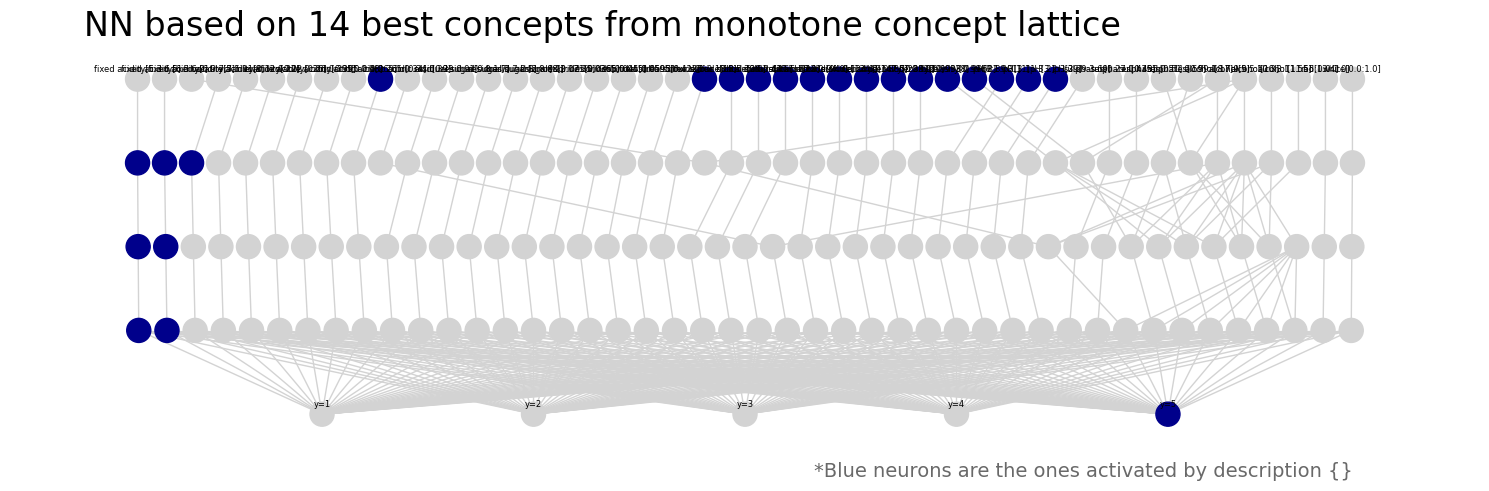

In [365]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 14 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [347]:
cn.fit(X_test_bin, y_test)

In [348]:
print('Class prediction', cn.predict(X_test_bin).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test_bin).detach().numpy())
print('True class', y_test.values)

Class prediction [2 2 2 3 2 2 3 2 3 2 2 3 2 3 3 2 3 2 2 2 3 2 3 3 3 2 2 2 3 2 3 2 3 3 2 3 2
 2 2 2 2 3 3 3 3 3]
Class prediction with probabilities [[1.64611028e-14 3.52051050e-14 9.93459821e-01 6.54021278e-03
  1.14985712e-13]
 [1.55610947e-14 3.18280994e-15 1.00000000e+00 1.04746160e-11
  1.48789486e-14]
 [1.02447947e-16 1.91611922e-17 1.00000000e+00 3.49184780e-15
  9.01771525e-17]
 [2.71302465e-08 7.69262254e-09 1.88980009e-02 9.81101930e-01
  3.50914071e-08]
 [1.02447947e-16 1.91611922e-17 1.00000000e+00 3.49184780e-15
  9.01771525e-17]
 [2.91265195e-07 3.14787144e-07 9.99532461e-01 4.66607627e-04
  4.11054259e-07]
 [1.05754891e-12 1.19510330e-11 3.40831298e-06 9.99996543e-01
  1.09034587e-11]
 [2.91265195e-07 3.14787144e-07 9.99532461e-01 4.66607627e-04
  4.11054259e-07]
 [9.25233358e-16 2.50839553e-15 9.19347514e-08 9.99999881e-01
  8.04845116e-15]
 [7.99026677e-15 1.79906812e-15 1.00000000e+00 2.57839261e-08
  1.55050990e-14]
 [1.55610947e-14 3.18280994e-15 1.00000000e+00 1.047

In [357]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train_bin, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [1 2 3 4 5]

In [356]:
y_train.value_counts()

quality
3    51
2    30
4    17
5     5
1     4
Name: count, dtype: int64

In [291]:
edge_weights = cn.edge_weights_from_network()

KeyError: (0, 67)

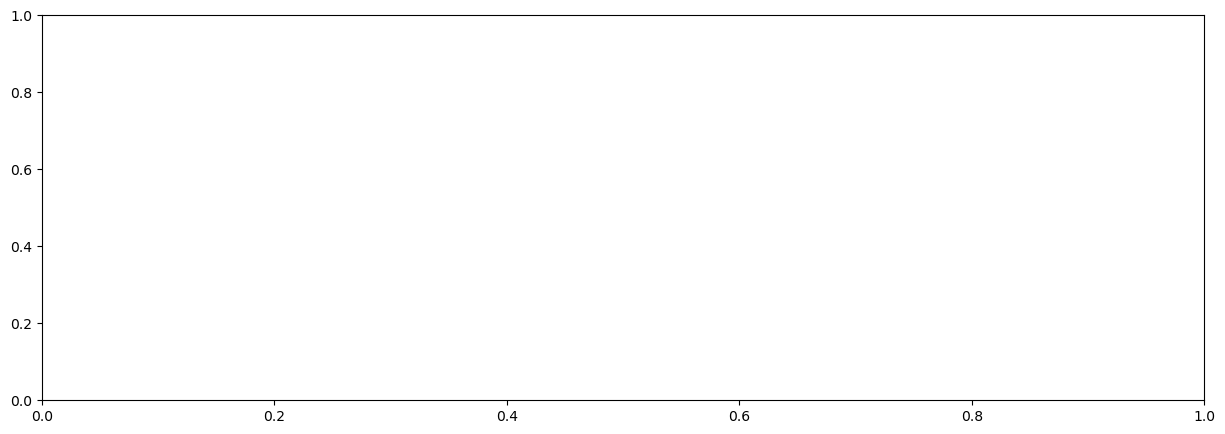

In [318]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [296]:
X_train

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3585,white,7.0,0.24,0.35,1.0,0.032,42.0,104.0,0.98988,3.16,0.37,11.7
2957,white,6.4,0.12,0.30,1.1,0.031,37.0,94.0,0.98986,3.01,0.56,11.7
1101,white,6.3,0.17,0.42,2.8,0.028,45.0,107.0,0.99080,3.27,0.43,11.8
4440,white,6.7,0.34,0.31,16.4,0.051,20.0,146.0,0.99834,3.06,0.54,9.1
1814,white,8.2,0.42,0.29,4.1,0.030,31.0,100.0,0.99110,3.00,0.32,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...
4990,red,8.6,0.49,0.29,2.0,0.110,19.0,133.0,0.99720,2.93,1.98,9.8
3952,white,7.0,0.16,0.30,2.6,0.043,34.0,90.0,0.99047,2.88,0.47,11.2
3890,white,6.4,0.38,0.26,8.2,0.043,28.0,98.0,0.99234,2.99,0.31,11.4
4464,white,6.6,0.26,0.56,15.4,0.053,32.0,141.0,0.99810,3.11,0.49,9.3


# 3. Malware detection 

In [452]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\uci_malware_detection.csv'
df = pd.read_csv(PATH)

In [453]:
df = df.drop_duplicates ()

In [454]:
y = df['Label']
X = df.drop(['Label'],axis=1)

In [455]:
# binarize
y = y.apply(lambda x: 0 if x=='malicious' else 1)

In [456]:
X.index = [str(id) for id in list(X.index)]

In [457]:
cols = X.columns
for col in cols:
        X[col] = X[col].apply(lambda x : False if (x==0 or x == '0') else True)

In [462]:
for col in X.columns:
    if len(X[col].value_counts()) <= 1:
        X.drop([col], axis=1, inplace=True)

In [423]:
#Feature selection based on decision tree

In [464]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [465]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (259 objects, 503 attributes, 26698 connections)
   |F_1|F_3|F_4|F_5|F_7|...|F_527|F_528|F_529|F_530|F_531|
177|  X|  X|   |  X|  X|...|     |    X|     |     |     |
293|  X|  X|   |  X|  X|...|     |     |     |    X|     |
267|  X|  X|   |  X|  X|...|     |    X|     |    X|     |
5  |  X|  X|   |  X|  X|...|     |     |     |     |     |
213|  X|  X|   |  X|  X|...|     |     |     |    X|     |
368|  X|  X|   |  X|  X|...|     |     |    X|     |    X|
327|  X|  X|   |  X|  X|...|     |     |     |    X|     |
162|  X|  X|   |  X|  X|...|     |     |     |    X|     |
301|  X|  X|   |  X|  X|...|     |     |     |     |     |
179|  X|  X|   |  X|  X|...|     |     |     |    X|     |
..........................................................
..........................................................
342|  X|  X|   |  X|  X|...|     |     |     |    X|     |
161|  X|  X|   |  X|  X|...|     |     |     |    X|     |
105|  X|  X|   |  X|  X|...|     |     |     |    X|

In [466]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')
len(L)

99

In [467]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

In [469]:
K_train.n_objects


259

In [492]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:8])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})#==K_train.n_objects


258

In [493]:
L.measures['f1_score']

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.38181818, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.31578947, 0.        , 0.        , 0.        ,
       0.        , 0.29370629, 0.        , 0.        , 0.        ,
       0.        , 0.2781457 , 0.        , 0.26923077, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.24561404,
       0.24137931, 0.23863636, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.22340426, 0.        ,
       0.21649485, 0.        , 0.        , 0.        , 0.        ,
       0.21      , 0.        , 0.        , 0.        , 0.     

In [496]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [497]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [498]:
descr = {'F_1', 'F_2', 'F_3', 'F_4'}

traced = cn.trace_description(descr, include_targets=False)

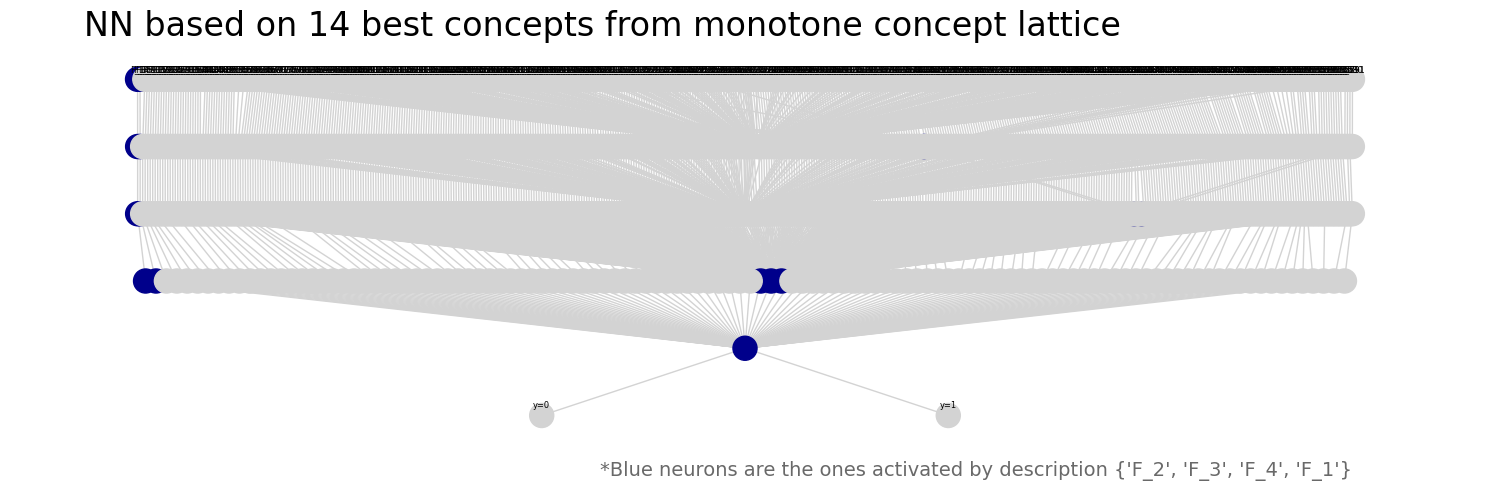

In [499]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 14 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [500]:
cn.fit(X_train, y_train)

In [506]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
Class prediction with probabilities [[0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.05304378]
 [0.9469562  0.053

In [515]:
f1_score(cn.predict(X_test).numpy(), y_test)

0.0

In [514]:
cn.predict(X_test).numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [512]:
y_test

128    0
52     1
196    0
256    0
319    0
      ..
314    0
209    0
205    0
243    0
175    0
Name: Label, Length: 112, dtype: int64

In [502]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred))

[[86  0]
 [ 0 26]]
f1_score is  1.0


In [503]:
edge_weights = cn.edge_weights_from_network()

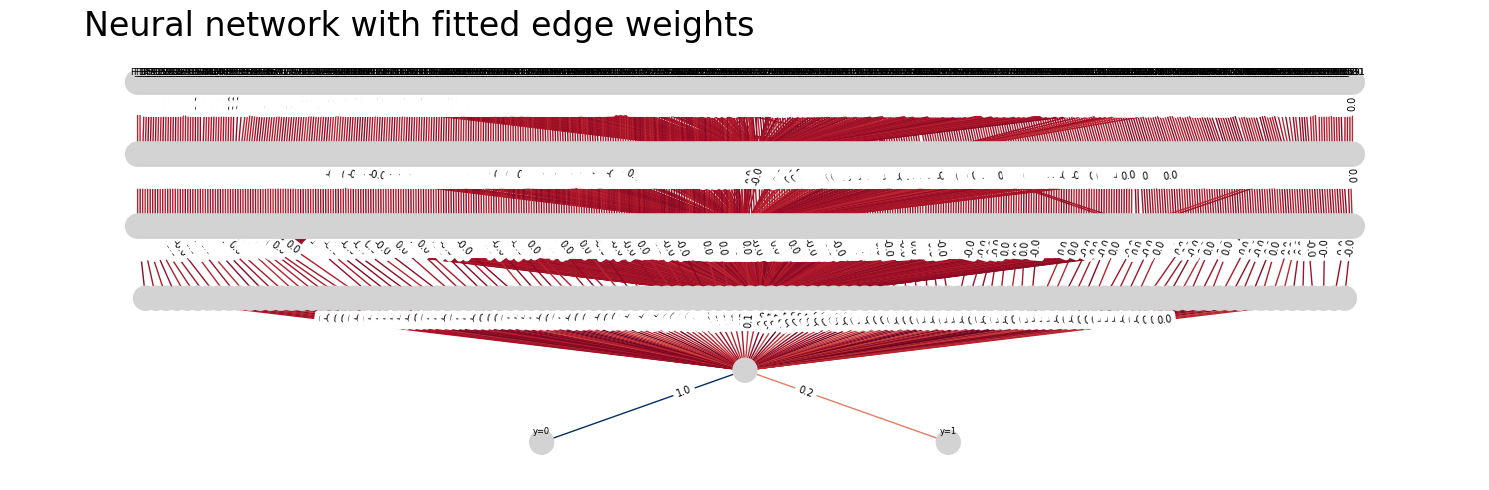

In [504]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()